In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = True

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_md_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:54 - loss: 0.2203 - STD: 2.0229e-04 - MAE: 0.4575

 4/74 [>.............................] - ETA: 2s - loss: 0.0771 - STD: 6.2047e-04 - MAE: 0.2128  

 5/74 [=>............................] - ETA: 2s - loss: 0.0686 - STD: 5.5380e-04 - MAE: 0.2005

 6/74 [=>............................] - ETA: 3s - loss: 0.0637 - STD: 4.9138e-04 - MAE: 0.1950

 7/74 [=>............................] - ETA: 3s - loss: 0.0609 - STD: 4.3808e-04 - MAE: 0.1927

 8/74 [==>...........................] - ETA: 3s - loss: 0.0589 - STD: 3.9412e-04 - MAE: 0.1914

 9/74 [==>...........................] - ETA: 3s - loss: 0.0574 - STD: 3.5784e-04 - MAE: 0.1904

10/74 [===>..........................] - ETA: 3s - loss: 0.0559 - STD: 3.2800e-04 - MAE: 0.1890

11/74 [===>..........................] - ETA: 3s - loss: 0.0545 - STD: 3.0353e-04 - MAE: 0.1872

12/74 [===>..........................] - ETA: 3s - loss: 0.0531 - STD: 2.8361e-04 - MAE: 0.1850

13/74 [====>.........................] - ETA: 3s - loss: 0.0516 - STD: 2.6756e-04 - MAE: 0.1821

14/74 [====>.........................] - ETA: 3s - loss: 0.0500 - STD: 2.5476e-04 - MAE: 0.1784

15/74 [=====>........................] - ETA: 3s - loss: 0.0482 - STD: 2.4458e-04 - MAE: 0.1737

16/74 [=====>........................] - ETA: 3s - loss: 0.0464 - STD: 2.3664e-04 - MAE: 0.1683

17/74 [=====>........................] - ETA: 3s - loss: 0.0445 - STD: 2.3056e-04 - MAE: 0.1623

18/74 [======>.......................] - ETA: 3s - loss: 0.0427 - STD: 2.2560e-04 - MAE: 0.1566

19/74 [======>.......................] - ETA: 3s - loss: 0.0411 - STD: 2.2148e-04 - MAE: 0.1525

20/74 [=======>......................] - ETA: 3s - loss: 0.0397 - STD: 2.1771e-04 - MAE: 0.1496

21/74 [=======>......................] - ETA: 3s - loss: 0.0386 - STD: 2.1423e-04 - MAE: 0.1478

22/74 [=======>......................] - ETA: 3s - loss: 0.0377 - STD: 2.1098e-04 - MAE: 0.1467

23/74 [========>.....................] - ETA: 3s - loss: 0.0369 - STD: 2.0779e-04 - MAE: 0.1458

24/74 [========>.....................] - ETA: 3s - loss: 0.0361 - STD: 2.0465e-04 - MAE: 0.1448

25/74 [=========>....................] - ETA: 3s - loss: 0.0354 - STD: 2.0171e-04 - MAE: 0.1436

26/74 [=========>....................] - ETA: 3s - loss: 0.0346 - STD: 1.9894e-04 - MAE: 0.1420

27/74 [=========>....................] - ETA: 3s - loss: 0.0338 - STD: 1.9639e-04 - MAE: 0.1400

28/74 [==========>...................] - ETA: 2s - loss: 0.0330 - STD: 1.9387e-04 - MAE: 0.1377

29/74 [==========>...................] - ETA: 2s - loss: 0.0323 - STD: 1.9153e-04 - MAE: 0.1352

30/74 [===========>..................] - ETA: 2s - loss: 0.0316 - STD: 1.8933e-04 - MAE: 0.1328

31/74 [===========>..................] - ETA: 2s - loss: 0.0310 - STD: 1.8730e-04 - MAE: 0.1304

32/74 [===========>..................] - ETA: 2s - loss: 0.0305 - STD: 1.8538e-04 - MAE: 0.1282

33/74 [============>.................] - ETA: 2s - loss: 0.0300 - STD: 1.8365e-04 - MAE: 0.1263

34/74 [============>.................] - ETA: 2s - loss: 0.0295 - STD: 1.8209e-04 - MAE: 0.1244

35/74 [=============>................] - ETA: 2s - loss: 0.0291 - STD: 1.8075e-04 - MAE: 0.1226

36/74 [=============>................] - ETA: 2s - loss: 0.0286 - STD: 1.7960e-04 - MAE: 0.1209

37/74 [==============>...............] - ETA: 2s - loss: 0.0282 - STD: 1.7861e-04 - MAE: 0.1193

38/74 [==============>...............] - ETA: 2s - loss: 0.0278 - STD: 1.7789e-04 - MAE: 0.1178

39/74 [==============>...............] - ETA: 2s - loss: 0.0274 - STD: 1.7734e-04 - MAE: 0.1163

40/74 [===============>..............] - ETA: 2s - loss: 0.0270 - STD: 1.7702e-04 - MAE: 0.1150

41/74 [===============>..............] - ETA: 2s - loss: 0.0267 - STD: 1.7691e-04 - MAE: 0.1139

42/74 [================>.............] - ETA: 2s - loss: 0.0263 - STD: 1.7694e-04 - MAE: 0.1130

43/74 [================>.............] - ETA: 2s - loss: 0.0260 - STD: 1.7726e-04 - MAE: 0.1122

44/74 [================>.............] - ETA: 1s - loss: 0.0257 - STD: 1.7760e-04 - MAE: 0.1115

45/74 [=================>............] - ETA: 1s - loss: 0.0254 - STD: 1.7809e-04 - MAE: 0.1109

46/74 [=================>............] - ETA: 1s - loss: 0.0251 - STD: 1.7861e-04 - MAE: 0.1104

47/74 [==================>...........] - ETA: 1s - loss: 0.0249 - STD: 1.7929e-04 - MAE: 0.1098

48/74 [==================>...........] - ETA: 1s - loss: 0.0246 - STD: 1.8008e-04 - MAE: 0.1092

49/74 [==================>...........] - ETA: 1s - loss: 0.0244 - STD: 1.8092e-04 - MAE: 0.1086

50/74 [===================>..........] - ETA: 1s - loss: 0.0241 - STD: 1.8176e-04 - MAE: 0.1078

51/74 [===================>..........] - ETA: 1s - loss: 0.0238 - STD: 1.8264e-04 - MAE: 0.1071

52/74 [====================>.........] - ETA: 1s - loss: 0.0236 - STD: 1.8372e-04 - MAE: 0.1063

53/74 [====================>.........] - ETA: 1s - loss: 0.0234 - STD: 1.8483e-04 - MAE: 0.1055

54/74 [====================>.........] - ETA: 1s - loss: 0.0232 - STD: 1.8600e-04 - MAE: 0.1047

55/74 [=====================>........] - ETA: 1s - loss: 0.0230 - STD: 1.8723e-04 - MAE: 0.1039

56/74 [=====================>........] - ETA: 1s - loss: 0.0228 - STD: 1.8860e-04 - MAE: 0.1032

57/74 [======================>.......] - ETA: 1s - loss: 0.0226 - STD: 1.9006e-04 - MAE: 0.1025

58/74 [======================>.......] - ETA: 1s - loss: 0.0224 - STD: 1.9169e-04 - MAE: 0.1018

59/74 [======================>.......] - ETA: 0s - loss: 0.0222 - STD: 1.9336e-04 - MAE: 0.1011

60/74 [=======================>......] - ETA: 1s - loss: 0.0222 - STD: 1.9515e-04 - MAE: 0.1005

63/74 [========================>.....] - ETA: 0s - loss: 0.0217 - STD: 2.0170e-04 - MAE: 0.0990

65/74 [=========================>....] - ETA: 0s - loss: 0.0214 - STD: 2.0690e-04 - MAE: 0.0982

66/74 [=========================>....] - ETA: 0s - loss: 0.0213 - STD: 2.0978e-04 - MAE: 0.0979

67/74 [==========================>...] - ETA: 0s - loss: 0.0211 - STD: 2.1264e-04 - MAE: 0.0976

68/74 [==========================>...] - ETA: 0s - loss: 0.0210 - STD: 2.1563e-04 - MAE: 0.0972

69/74 [==========================>...] - ETA: 0s - loss: 0.0209 - STD: 2.1884e-04 - MAE: 0.0969

70/74 [===========================>..] - ETA: 0s - loss: 0.0207 - STD: 2.2221e-04 - MAE: 0.0965

71/74 [===========================>..] - ETA: 0s - loss: 0.0206 - STD: 2.2562e-04 - MAE: 0.0962

72/74 [============================>.] - ETA: 0s - loss: 0.0205 - STD: 2.2910e-04 - MAE: 0.0958

73/74 [============================>.] - ETA: 0s - loss: 0.0204 - STD: 2.3286e-04 - MAE: 0.0954

74/74 [==============================] - ETA: 0s - loss: 0.0203 - STD: 2.3681e-04 - MAE: 0.0951

74/74 [==============================] - 8s 83ms/step - loss: 0.0203 - STD: 2.3681e-04 - MAE: 0.0951 - val_loss: 0.0145 - val_STD: 3.5001e-04 - val_MAE: 0.0708


Epoch 2/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0123 - STD: 5.4356e-04 - MAE: 0.0673

 2/74 [..............................] - ETA: 5s - loss: 0.0124 - STD: 5.5489e-04 - MAE: 0.0673

 3/74 [>.............................] - ETA: 5s - loss: 0.0123 - STD: 5.6526e-04 - MAE: 0.0670

 4/74 [>.............................] - ETA: 4s - loss: 0.0121 - STD: 5.7709e-04 - MAE: 0.0667

 5/74 [=>............................] - ETA: 4s - loss: 0.0121 - STD: 5.8914e-04 - MAE: 0.0668

 6/74 [=>............................] - ETA: 4s - loss: 0.0120 - STD: 6.0242e-04 - MAE: 0.0667

 7/74 [=>............................] - ETA: 4s - loss: 0.0120 - STD: 6.1717e-04 - MAE: 0.0670

 8/74 [==>...........................] - ETA: 4s - loss: 0.0120 - STD: 6.3247e-04 - MAE: 0.0672

 9/74 [==>...........................] - ETA: 4s - loss: 0.0120 - STD: 6.4752e-04 - MAE: 0.0674

10/74 [===>..........................] - ETA: 4s - loss: 0.0120 - STD: 6.6438e-04 - MAE: 0.0677

11/74 [===>..........................] - ETA: 4s - loss: 0.0120 - STD: 6.8219e-04 - MAE: 0.0681

12/74 [===>..........................] - ETA: 4s - loss: 0.0119 - STD: 6.9957e-04 - MAE: 0.0682

13/74 [====>.........................] - ETA: 4s - loss: 0.0120 - STD: 7.1940e-04 - MAE: 0.0685

14/74 [====>.........................] - ETA: 4s - loss: 0.0120 - STD: 7.3789e-04 - MAE: 0.0686

15/74 [=====>........................] - ETA: 3s - loss: 0.0120 - STD: 7.5793e-04 - MAE: 0.0687

16/74 [=====>........................] - ETA: 3s - loss: 0.0119 - STD: 7.7756e-04 - MAE: 0.0687

17/74 [=====>........................] - ETA: 3s - loss: 0.0119 - STD: 7.9818e-04 - MAE: 0.0686

18/74 [======>.......................] - ETA: 3s - loss: 0.0118 - STD: 8.1926e-04 - MAE: 0.0685

19/74 [======>.......................] - ETA: 3s - loss: 0.0118 - STD: 8.4142e-04 - MAE: 0.0684

20/74 [=======>......................] - ETA: 3s - loss: 0.0119 - STD: 8.6577e-04 - MAE: 0.0684

21/74 [=======>......................] - ETA: 3s - loss: 0.0118 - STD: 8.9087e-04 - MAE: 0.0683

22/74 [=======>......................] - ETA: 3s - loss: 0.0119 - STD: 9.1672e-04 - MAE: 0.0683

23/74 [========>.....................] - ETA: 3s - loss: 0.0119 - STD: 9.4392e-04 - MAE: 0.0682

24/74 [========>.....................] - ETA: 3s - loss: 0.0119 - STD: 9.7181e-04 - MAE: 0.0682

25/74 [=========>....................] - ETA: 3s - loss: 0.0118 - STD: 0.0010 - MAE: 0.0682    

26/74 [=========>....................] - ETA: 3s - loss: 0.0118 - STD: 0.0010 - MAE: 0.0682

27/74 [=========>....................] - ETA: 3s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0682

28/74 [==========>...................] - ETA: 3s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0682

29/74 [==========>...................] - ETA: 3s - loss: 0.0118 - STD: 0.0011 - MAE: 0.0683

30/74 [===========>..................] - ETA: 2s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0683

31/74 [===========>..................] - ETA: 2s - loss: 0.0118 - STD: 0.0012 - MAE: 0.0683

32/74 [===========>..................] - ETA: 2s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0682

33/74 [============>.................] - ETA: 2s - loss: 0.0118 - STD: 0.0013 - MAE: 0.0682

34/74 [============>.................] - ETA: 2s - loss: 0.0117 - STD: 0.0014 - MAE: 0.0682

35/74 [=============>................] - ETA: 2s - loss: 0.0117 - STD: 0.0014 - MAE: 0.0682

36/74 [=============>................] - ETA: 2s - loss: 0.0117 - STD: 0.0015 - MAE: 0.0681

37/74 [==============>...............] - ETA: 2s - loss: 0.0117 - STD: 0.0015 - MAE: 0.0681

38/74 [==============>...............] - ETA: 2s - loss: 0.0117 - STD: 0.0016 - MAE: 0.0681

39/74 [==============>...............] - ETA: 2s - loss: 0.0117 - STD: 0.0016 - MAE: 0.0680

40/74 [===============>..............] - ETA: 2s - loss: 0.0117 - STD: 0.0017 - MAE: 0.0680

41/74 [===============>..............] - ETA: 2s - loss: 0.0117 - STD: 0.0018 - MAE: 0.0680

42/74 [================>.............] - ETA: 2s - loss: 0.0117 - STD: 0.0018 - MAE: 0.0680

43/74 [================>.............] - ETA: 2s - loss: 0.0117 - STD: 0.0019 - MAE: 0.0680

44/74 [================>.............] - ETA: 2s - loss: 0.0117 - STD: 0.0020 - MAE: 0.0680

45/74 [=================>............] - ETA: 1s - loss: 0.0117 - STD: 0.0021 - MAE: 0.0680

46/74 [=================>............] - ETA: 1s - loss: 0.0116 - STD: 0.0022 - MAE: 0.0679

47/74 [==================>...........] - ETA: 1s - loss: 0.0116 - STD: 0.0023 - MAE: 0.0679

48/74 [==================>...........] - ETA: 1s - loss: 0.0116 - STD: 0.0024 - MAE: 0.0679

49/74 [==================>...........] - ETA: 1s - loss: 0.0116 - STD: 0.0025 - MAE: 0.0678

50/74 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.0026 - MAE: 0.0677

51/74 [===================>..........] - ETA: 1s - loss: 0.0116 - STD: 0.0028 - MAE: 0.0676

52/74 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0029 - MAE: 0.0676

53/74 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0031 - MAE: 0.0675

54/74 [====================>.........] - ETA: 1s - loss: 0.0115 - STD: 0.0032 - MAE: 0.0674

55/74 [=====================>........] - ETA: 1s - loss: 0.0115 - STD: 0.0034 - MAE: 0.0673

56/74 [=====================>........] - ETA: 1s - loss: 0.0115 - STD: 0.0036 - MAE: 0.0672

57/74 [======================>.......] - ETA: 1s - loss: 0.0114 - STD: 0.0038 - MAE: 0.0672

58/74 [======================>.......] - ETA: 1s - loss: 0.0114 - STD: 0.0040 - MAE: 0.0671

59/74 [======================>.......] - ETA: 1s - loss: 0.0114 - STD: 0.0042 - MAE: 0.0670

60/74 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 0.0044 - MAE: 0.0669

61/74 [=======================>......] - ETA: 0s - loss: 0.0113 - STD: 0.0047 - MAE: 0.0668

62/74 [========================>.....] - ETA: 0s - loss: 0.0113 - STD: 0.0050 - MAE: 0.0666

63/74 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 0.0052 - MAE: 0.0665

64/74 [========================>.....] - ETA: 0s - loss: 0.0112 - STD: 0.0055 - MAE: 0.0663

66/74 [=========================>....] - ETA: 0s - loss: 0.0111 - STD: 0.0062 - MAE: 0.0660

67/74 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 0.0065 - MAE: 0.0658

68/74 [==========================>...] - ETA: 0s - loss: 0.0110 - STD: 0.0069 - MAE: 0.0656

69/74 [==========================>...] - ETA: 0s - loss: 0.0109 - STD: 0.0073 - MAE: 0.0654

70/74 [===========================>..] - ETA: 0s - loss: 0.0109 - STD: 0.0077 - MAE: 0.0653

71/74 [===========================>..] - ETA: 0s - loss: 0.0108 - STD: 0.0082 - MAE: 0.0651

72/74 [============================>.] - ETA: 0s - loss: 0.0108 - STD: 0.0087 - MAE: 0.0649

73/74 [============================>.] - ETA: 0s - loss: 0.0107 - STD: 0.0091 - MAE: 0.0646

74/74 [==============================] - ETA: 0s - loss: 0.0106 - STD: 0.0096 - MAE: 0.0644

74/74 [==============================] - 5s 71ms/step - loss: 0.0106 - STD: 0.0096 - MAE: 0.0644 - val_loss: 0.0071 - val_STD: 0.0324 - val_MAE: 0.0490


Epoch 3/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0060 - STD: 0.0493 - MAE: 0.0470

 2/74 [..............................] - ETA: 5s - loss: 0.0060 - STD: 0.0503 - MAE: 0.0468

 3/74 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0513 - MAE: 0.0463

 4/74 [>.............................] - ETA: 4s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0462

 5/74 [=>............................] - ETA: 4s - loss: 0.0056 - STD: 0.0537 - MAE: 0.0455

 6/74 [=>............................] - ETA: 4s - loss: 0.0055 - STD: 0.0550 - MAE: 0.0452

 7/74 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0561 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 4s - loss: 0.0052 - STD: 0.0585 - MAE: 0.0442

10/74 [===>..........................] - ETA: 4s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0439

11/74 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0435

12/74 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0618 - MAE: 0.0433

13/74 [====>.........................] - ETA: 3s - loss: 0.0049 - STD: 0.0627 - MAE: 0.0430

14/74 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0046 - STD: 0.0669 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0677 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0685 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0692 - MAE: 0.0411

22/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0699 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0706 - MAE: 0.0408

24/74 [========>.....................] - ETA: 3s - loss: 0.0043 - STD: 0.0713 - MAE: 0.0406

25/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0719 - MAE: 0.0404

26/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0726 - MAE: 0.0402

27/74 [=========>....................] - ETA: 3s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0401

28/74 [==========>...................] - ETA: 3s - loss: 0.0041 - STD: 0.0735 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0745 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0750 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0755 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0392

34/74 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0389

37/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0388

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0387

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0386

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0385

41/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0786 - MAE: 0.0384

42/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0383

43/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0382

44/74 [================>.............] - ETA: 2s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0381

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0380

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0380

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0802 - MAE: 0.0379

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0804 - MAE: 0.0378

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0806 - MAE: 0.0377

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0809 - MAE: 0.0377

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0810 - MAE: 0.0376

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0812 - MAE: 0.0376

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0814 - MAE: 0.0375

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0816 - MAE: 0.0374

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0819 - MAE: 0.0374

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0821 - MAE: 0.0373

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0822 - MAE: 0.0373

58/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0824 - MAE: 0.0372

59/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0826 - MAE: 0.0371

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0828 - MAE: 0.0371

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0830 - MAE: 0.0371

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0832 - MAE: 0.0370

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0834 - MAE: 0.0370

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0835 - MAE: 0.0369

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0836 - MAE: 0.0369

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0838 - MAE: 0.0368

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0839 - MAE: 0.0368

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0841 - MAE: 0.0367

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0842 - MAE: 0.0367

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0844 - MAE: 0.0366

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0845 - MAE: 0.0366

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0846 - MAE: 0.0365

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0848 - MAE: 0.0365

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0849 - MAE: 0.0364

74/74 [==============================] - 5s 71ms/step - loss: 0.0033 - STD: 0.0849 - MAE: 0.0364 - val_loss: 0.0029 - val_STD: 0.0737 - val_MAE: 0.0352


Epoch 4/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0936 - MAE: 0.0329

 2/74 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0938 - MAE: 0.0329

 3/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0951 - MAE: 0.0334

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0333

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0947 - MAE: 0.0333

 6/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0333

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0332

 8/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0950 - MAE: 0.0332

 9/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0949 - MAE: 0.0332

10/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0948 - MAE: 0.0331

11/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0947 - MAE: 0.0331

12/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0946 - MAE: 0.0331

13/74 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0331

14/74 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0945 - MAE: 0.0331

15/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0946 - MAE: 0.0331

16/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0947 - MAE: 0.0330

17/74 [=====>........................] - ETA: 3s - loss: 0.0025 - STD: 0.0947 - MAE: 0.0330

18/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0330

19/74 [======>.......................] - ETA: 3s - loss: 0.0025 - STD: 0.0943 - MAE: 0.0329

20/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0329

21/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0329

22/74 [=======>......................] - ETA: 3s - loss: 0.0025 - STD: 0.0944 - MAE: 0.0329

23/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0945 - MAE: 0.0329

24/74 [========>.....................] - ETA: 3s - loss: 0.0025 - STD: 0.0945 - MAE: 0.0329

25/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0329

26/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0329

27/74 [=========>....................] - ETA: 3s - loss: 0.0025 - STD: 0.0946 - MAE: 0.0328

28/74 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0947 - MAE: 0.0329

29/74 [==========>...................] - ETA: 3s - loss: 0.0025 - STD: 0.0947 - MAE: 0.0328

30/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0328

31/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0328

32/74 [===========>..................] - ETA: 2s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0328

33/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0328

34/74 [============>.................] - ETA: 2s - loss: 0.0025 - STD: 0.0948 - MAE: 0.0328

35/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0328

36/74 [=============>................] - ETA: 2s - loss: 0.0025 - STD: 0.0949 - MAE: 0.0328

37/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0950 - MAE: 0.0327

38/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0951 - MAE: 0.0327

39/74 [==============>...............] - ETA: 2s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0328

40/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0952 - MAE: 0.0327

41/74 [===============>..............] - ETA: 2s - loss: 0.0025 - STD: 0.0953 - MAE: 0.0327

42/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0327

43/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0327

44/74 [================>.............] - ETA: 2s - loss: 0.0025 - STD: 0.0954 - MAE: 0.0327

45/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0327

46/74 [=================>............] - ETA: 1s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0327

47/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0327

48/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0955 - MAE: 0.0327

49/74 [==================>...........] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0326

50/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0326

51/74 [===================>..........] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0326

52/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0326

53/74 [====================>.........] - ETA: 1s - loss: 0.0025 - STD: 0.0956 - MAE: 0.0326

55/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0325

56/74 [=====================>........] - ETA: 1s - loss: 0.0025 - STD: 0.0957 - MAE: 0.0325

57/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0325

58/74 [======================>.......] - ETA: 1s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0325

59/74 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.0958 - MAE: 0.0325

60/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0959 - MAE: 0.0325

61/74 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.0959 - MAE: 0.0325

62/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0959 - MAE: 0.0325

63/74 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.0960 - MAE: 0.0325

64/74 [========================>.....] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0324

65/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0960 - MAE: 0.0324

66/74 [=========================>....] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0324

67/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0324

68/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0324

69/74 [==========================>...] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0324

70/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0324

71/74 [===========================>..] - ETA: 0s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0323

72/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0961 - MAE: 0.0323

73/74 [============================>.] - ETA: 0s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0323

74/74 [==============================] - ETA: 0s - loss: 0.0024 - STD: 0.0962 - MAE: 0.0323

74/74 [==============================] - 5s 70ms/step - loss: 0.0024 - STD: 0.0962 - MAE: 0.0323 - val_loss: 0.0026 - val_STD: 0.0749 - val_MAE: 0.0329


Epoch 5/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.0971 - MAE: 0.0317

 2/74 [..............................] - ETA: 5s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0319

 3/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0970 - MAE: 0.0317

 4/74 [>.............................] - ETA: 4s - loss: 0.0023 - STD: 0.0979 - MAE: 0.0317

 5/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0318

 6/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0317

 7/74 [=>............................] - ETA: 4s - loss: 0.0023 - STD: 0.0972 - MAE: 0.0317

 8/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0317

 9/74 [==>...........................] - ETA: 4s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0316

10/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0316

11/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0316

12/74 [===>..........................] - ETA: 4s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0316

13/74 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

14/74 [====>.........................] - ETA: 4s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

15/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0315

16/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0976 - MAE: 0.0315

17/74 [=====>........................] - ETA: 3s - loss: 0.0023 - STD: 0.0974 - MAE: 0.0315

18/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0973 - MAE: 0.0314

19/74 [======>.......................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

20/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0315

21/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

22/74 [=======>......................] - ETA: 3s - loss: 0.0023 - STD: 0.0975 - MAE: 0.0314

24/74 [========>.....................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0315

25/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0314

26/74 [=========>....................] - ETA: 3s - loss: 0.0023 - STD: 0.0977 - MAE: 0.0314

27/74 [=========>....................] - ETA: 3s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

28/74 [==========>...................] - ETA: 3s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

29/74 [==========>...................] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

30/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

31/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0314

32/74 [===========>..................] - ETA: 2s - loss: 0.0022 - STD: 0.0976 - MAE: 0.0314

33/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0314

34/74 [============>.................] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0314

35/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0977 - MAE: 0.0313

36/74 [=============>................] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0313

37/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

38/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

39/74 [==============>...............] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

40/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

41/74 [===============>..............] - ETA: 2s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0313

42/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

43/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0313

44/74 [================>.............] - ETA: 2s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0312

45/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0313

46/74 [=================>............] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

47/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

48/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

49/74 [==================>...........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

50/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

51/74 [===================>..........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

52/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0312

53/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

54/74 [====================>.........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

55/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

56/74 [=====================>........] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0311

57/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0311

58/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0311

59/74 [======================>.......] - ETA: 1s - loss: 0.0022 - STD: 0.0978 - MAE: 0.0311

60/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

61/74 [=======================>......] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

62/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0311

63/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

64/74 [========================>.....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

65/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

66/74 [=========================>....] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

67/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

68/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

69/74 [==========================>...] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

70/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

71/74 [===========================>..] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

72/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0979 - MAE: 0.0310

73/74 [============================>.] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

74/74 [==============================] - ETA: 0s - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310

74/74 [==============================] - 5s 70ms/step - loss: 0.0022 - STD: 0.0980 - MAE: 0.0310 - val_loss: 0.0024 - val_STD: 0.0771 - val_MAE: 0.0317


Epoch 6/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0022 - STD: 0.1011 - MAE: 0.0309

 2/74 [..............................] - ETA: 4s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0305

 3/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0305

 4/74 [>.............................] - ETA: 4s - loss: 0.0021 - STD: 0.0977 - MAE: 0.0305

 5/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0974 - MAE: 0.0305

 6/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0975 - MAE: 0.0305

 7/74 [=>............................] - ETA: 4s - loss: 0.0021 - STD: 0.0979 - MAE: 0.0305

 8/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0305

 9/74 [==>...........................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

10/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0984 - MAE: 0.0306

11/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0306

12/74 [===>..........................] - ETA: 4s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

13/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0985 - MAE: 0.0305

14/74 [====>.........................] - ETA: 4s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

15/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0986 - MAE: 0.0305

16/74 [=====>........................] - ETA: 3s - loss: 0.0021 - STD: 0.0988 - MAE: 0.0305

18/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305

19/74 [======>.......................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0305

20/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

21/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

22/74 [=======>......................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

23/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0304

24/74 [========>.....................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0304

25/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

26/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0304

27/74 [=========>....................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

28/74 [==========>...................] - ETA: 3s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

29/74 [==========>...................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

30/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

31/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

32/74 [===========>..................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

33/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0991 - MAE: 0.0303

34/74 [============>.................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

35/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0992 - MAE: 0.0303

36/74 [=============>................] - ETA: 2s - loss: 0.0021 - STD: 0.0990 - MAE: 0.0303

37/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

38/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0303

39/74 [==============>...............] - ETA: 2s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0302

40/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0302

41/74 [===============>..............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

42/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

43/74 [================>.............] - ETA: 2s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0302

44/74 [================>.............] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

45/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

46/74 [=================>............] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

47/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

48/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

49/74 [==================>...........] - ETA: 1s - loss: 0.0020 - STD: 0.0988 - MAE: 0.0302

50/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

51/74 [===================>..........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

52/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

53/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

54/74 [====================>.........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

55/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0302

56/74 [=====================>........] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

57/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

58/74 [======================>.......] - ETA: 1s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0302

59/74 [======================>.......] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

60/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

61/74 [=======================>......] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

62/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

63/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

64/74 [========================>.....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

65/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0989 - MAE: 0.0301

66/74 [=========================>....] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

67/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0301

68/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

69/74 [==========================>...] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

70/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

71/74 [===========================>..] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

72/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

73/74 [============================>.] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

74/74 [==============================] - ETA: 0s - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300

74/74 [==============================] - 5s 70ms/step - loss: 0.0020 - STD: 0.0990 - MAE: 0.0300 - val_loss: 0.0022 - val_STD: 0.0775 - val_MAE: 0.0304


Epoch 7/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0294

 2/74 [..............................] - ETA: 5s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0298

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0990 - MAE: 0.0296

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0296

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0296

 7/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0296

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0296

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0295

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0295

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0295

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0295

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0294

14/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0294

15/74 [=====>........................] - ETA: 4s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0294

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0294

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0294

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0294

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0293

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0293

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0293

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0293

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

29/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0292

30/74 [===========>..................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0292

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

33/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0292

34/74 [============>.................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0292

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0292

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0292

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

59/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

63/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

64/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

65/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

66/74 [=========================>....] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

67/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

68/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

69/74 [==========================>...] - ETA: 0s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0291

70/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

71/74 [===========================>..] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

72/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

73/74 [============================>.] - ETA: 0s - loss: 0.0019 - STD: 0.0997 - MAE: 0.0291

74/74 [==============================] - ETA: 0s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291

74/74 [==============================] - 5s 71ms/step - loss: 0.0019 - STD: 0.0996 - MAE: 0.0291 - val_loss: 0.0021 - val_STD: 0.0799 - val_MAE: 0.0298


Epoch 8/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0283

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0285

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1010 - MAE: 0.0288

 4/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0287

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0995 - MAE: 0.0287

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0989 - MAE: 0.0288

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0991 - MAE: 0.0288

 8/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0289

 9/74 [==>...........................] - ETA: 4s - loss: 0.0019 - STD: 0.0988 - MAE: 0.0289

10/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0992 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0991 - MAE: 0.0291

12/74 [===>..........................] - ETA: 4s - loss: 0.0019 - STD: 0.0994 - MAE: 0.0291

13/74 [====>.........................] - ETA: 4s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0291

14/74 [====>.........................] - ETA: 3s - loss: 0.0019 - STD: 0.0995 - MAE: 0.0290

15/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

17/74 [=====>........................] - ETA: 3s - loss: 0.0019 - STD: 0.0996 - MAE: 0.0290

18/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0999 - MAE: 0.0290

19/74 [======>.......................] - ETA: 3s - loss: 0.0019 - STD: 0.0998 - MAE: 0.0290

20/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

21/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

22/74 [=======>......................] - ETA: 3s - loss: 0.0019 - STD: 0.1000 - MAE: 0.0290

23/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

24/74 [========>.....................] - ETA: 3s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

25/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

26/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

27/74 [=========>....................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

28/74 [==========>...................] - ETA: 3s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

29/74 [==========>...................] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

30/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

31/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

32/74 [===========>..................] - ETA: 2s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0289

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0289

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0289

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1003 - MAE: 0.0290

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0291

58/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

59/74 [======================>.......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1002 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0019 - STD: 0.1001 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0290

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0290

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0290

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289

74/74 [==============================] - 5s 70ms/step - loss: 0.0018 - STD: 0.1001 - MAE: 0.0289 - val_loss: 0.0021 - val_STD: 0.0799 - val_MAE: 0.0301


Epoch 9/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.0989 - MAE: 0.0285

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0285

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0285

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0285

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1003 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0283

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0282

14/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0282

15/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0282

16/74 [=====>........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0282

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0284

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0284

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0284

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0285

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0285

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0286

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0286

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0287

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0288

29/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

30/74 [===========>..................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0288

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0289

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0289

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1008 - MAE: 0.0291

35/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

36/74 [=============>................] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0293

38/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0293

39/74 [==============>...............] - ETA: 2s - loss: 0.0019 - STD: 0.1007 - MAE: 0.0293

40/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0293

41/74 [===============>..............] - ETA: 2s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0293

42/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0293

43/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

44/74 [================>.............] - ETA: 2s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0292

45/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0292

46/74 [=================>............] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

47/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0292

48/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

49/74 [==================>...........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

50/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

51/74 [===================>..........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0292

52/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

53/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

54/74 [====================>.........] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

55/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

56/74 [=====================>........] - ETA: 1s - loss: 0.0019 - STD: 0.1006 - MAE: 0.0291

57/74 [======================>.......] - ETA: 1s - loss: 0.0019 - STD: 0.1005 - MAE: 0.0291

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0291

59/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

60/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

61/74 [=======================>......] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

62/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

63/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

64/74 [========================>.....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

65/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

66/74 [=========================>....] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0290

67/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

68/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

69/74 [==========================>...] - ETA: 0s - loss: 0.0018 - STD: 0.1005 - MAE: 0.0289

70/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

71/74 [===========================>..] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

72/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

73/74 [============================>.] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

74/74 [==============================] - ETA: 0s - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289

74/74 [==============================] - 5s 71ms/step - loss: 0.0018 - STD: 0.1004 - MAE: 0.0289 - val_loss: 0.0021 - val_STD: 0.0797 - val_MAE: 0.0296


Epoch 10/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.0992 - MAE: 0.0281

 2/74 [..............................] - ETA: 5s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0280

 3/74 [>.............................] - ETA: 5s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0281

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0281

 5/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0280

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.0997 - MAE: 0.0280

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0281

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1001 - MAE: 0.0281

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.0998 - MAE: 0.0282

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0282

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

13/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0283

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0283

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.0999 - MAE: 0.0283

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1000 - MAE: 0.0283

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1001 - MAE: 0.0283

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0282

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0282

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0282

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1002 - MAE: 0.0282

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0282

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0281

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1002 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1004 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0282

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1005 - MAE: 0.0281

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

74/74 [==============================] - 5s 71ms/step - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280 - val_loss: 0.0020 - val_STD: 0.0792 - val_MAE: 0.0297


Epoch 11/10000


 1/74 [..............................] - ETA: 8s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0275

 2/74 [..............................] - ETA: 6s - loss: 0.0017 - STD: 0.0978 - MAE: 0.0275

 3/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.0988 - MAE: 0.0275

 4/74 [>.............................] - ETA: 5s - loss: 0.0017 - STD: 0.0990 - MAE: 0.0275

 5/74 [=>............................] - ETA: 5s - loss: 0.0017 - STD: 0.0996 - MAE: 0.0276

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1003 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

15/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

16/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0279

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0279

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

29/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0279

30/74 [===========>..................] - ETA: 3s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1006 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1007 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

44/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1008 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

74/74 [==============================] - 5s 71ms/step - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280 - val_loss: 0.0021 - val_STD: 0.0807 - val_MAE: 0.0301


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0278

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0278

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0277

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0277

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0277

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0276

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0276

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0277

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0277

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0278

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0278

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0278

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0278

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0278

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0280

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279 - val_loss: 0.0021 - val_STD: 0.0814 - val_MAE: 0.0304


Epoch 13/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0018 - STD: 0.1029 - MAE: 0.0285

 2/74 [..............................] - ETA: 4s - loss: 0.0018 - STD: 0.1030 - MAE: 0.0282

 3/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0287

 5/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0283

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0285

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0286

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0284

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

11/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

12/74 [===>..........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0280

13/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

14/74 [====>.........................] - ETA: 3s - loss: 0.0017 - STD: 0.1009 - MAE: 0.0281

15/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0282

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

23/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

26/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

27/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

28/74 [==========>...................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0281

29/74 [==========>...................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

30/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

31/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

32/74 [===========>..................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

33/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

34/74 [============>.................] - ETA: 2s - loss: 0.0017 - STD: 0.1010 - MAE: 0.0281

35/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

36/74 [=============>................] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

37/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

38/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

39/74 [==============>...............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

40/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

41/74 [===============>..............] - ETA: 2s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

42/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

43/74 [================>.............] - ETA: 2s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0280

44/74 [================>.............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

45/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

46/74 [=================>............] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0279

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0278

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0278

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0279 - val_loss: 0.0021 - val_STD: 0.0817 - val_MAE: 0.0307


Epoch 14/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.1045 - MAE: 0.0283

 2/74 [..............................] - ETA: 4s - loss: 0.0020 - STD: 0.0996 - MAE: 0.0306

 3/74 [>.............................] - ETA: 4s - loss: 0.0019 - STD: 0.1008 - MAE: 0.0299

 4/74 [>.............................] - ETA: 4s - loss: 0.0018 - STD: 0.1017 - MAE: 0.0293

 5/74 [=>............................] - ETA: 4s - loss: 0.0019 - STD: 0.1004 - MAE: 0.0296

 6/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0293

 7/74 [=>............................] - ETA: 4s - loss: 0.0018 - STD: 0.1018 - MAE: 0.0291

 8/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0293

 9/74 [==>...........................] - ETA: 4s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0291

10/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0290

11/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0290

12/74 [===>..........................] - ETA: 4s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0288

13/74 [====>.........................] - ETA: 4s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0290

14/74 [====>.........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0291

15/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1006 - MAE: 0.0290

16/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0291

17/74 [=====>........................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0292

18/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0291

19/74 [======>.......................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0292

20/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0292

21/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0292

22/74 [=======>......................] - ETA: 3s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0293

23/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0293

24/74 [========>.....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0293

25/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0293

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1009 - MAE: 0.0293

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1007 - MAE: 0.0293

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1010 - MAE: 0.0292

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0292

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0291

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0291

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0290

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0290

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0289

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0289

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0288

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0288

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1011 - MAE: 0.0287

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0286

44/74 [================>.............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0285

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1012 - MAE: 0.0285

47/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0285

48/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

49/74 [==================>...........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

50/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

51/74 [===================>..........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

52/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

53/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

54/74 [====================>.........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

55/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0283

56/74 [=====================>........] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

57/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

58/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

59/74 [======================>.......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0282

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0282

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281

74/74 [==============================] - 5s 70ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0281 - val_loss: 0.0020 - val_STD: 0.0777 - val_MAE: 0.0288


Epoch 15/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0017 - STD: 0.0956 - MAE: 0.0278

 2/74 [..............................] - ETA: 4s - loss: 0.0017 - STD: 0.0985 - MAE: 0.0275

 3/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0998 - MAE: 0.0276

 4/74 [>.............................] - ETA: 4s - loss: 0.0017 - STD: 0.0997 - MAE: 0.0277

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1002 - MAE: 0.0276

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0276

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1003 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0275

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1008 - MAE: 0.0275

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0275

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0275

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0275

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0275

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0275

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0275

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0275

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0274

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

30/74 [===========>..................] - ETA: 3s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0274

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0274

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0274

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0274

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0274

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0275

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1015 - MAE: 0.0275 - val_loss: 0.0019 - val_STD: 0.0806 - val_MAE: 0.0288


Epoch 16/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0268

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

 3/74 [>.............................] - ETA: 5s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0274

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0275

 6/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0277

 7/74 [=>............................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0276

 8/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1023 - MAE: 0.0276

 9/74 [==>...........................] - ETA: 4s - loss: 0.0017 - STD: 0.1020 - MAE: 0.0278

10/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1018 - MAE: 0.0278

11/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1019 - MAE: 0.0278

12/74 [===>..........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

13/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1016 - MAE: 0.0279

14/74 [====>.........................] - ETA: 4s - loss: 0.0017 - STD: 0.1017 - MAE: 0.0279

15/74 [=====>........................] - ETA: 4s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0280

16/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0279

17/74 [=====>........................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0279

18/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1011 - MAE: 0.0281

19/74 [======>.......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0280

20/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1015 - MAE: 0.0281

21/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

22/74 [=======>......................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0283

24/74 [========>.....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0286

25/74 [=========>....................] - ETA: 3s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0285

26/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0288

27/74 [=========>....................] - ETA: 3s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

28/74 [==========>...................] - ETA: 3s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0289

29/74 [==========>...................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0292

30/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0292

31/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0293

32/74 [===========>..................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0293

33/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0293

34/74 [============>.................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0293

35/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0292

36/74 [=============>................] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0292

37/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0292

38/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1013 - MAE: 0.0292

39/74 [==============>...............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0291

40/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0291

41/74 [===============>..............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0291

42/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0291

43/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0290

44/74 [================>.............] - ETA: 2s - loss: 0.0018 - STD: 0.1016 - MAE: 0.0290

45/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0290

46/74 [=================>............] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0289

47/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

48/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0289

49/74 [==================>...........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

50/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

51/74 [===================>..........] - ETA: 1s - loss: 0.0018 - STD: 0.1015 - MAE: 0.0288

52/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0288

53/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

54/74 [====================>.........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

55/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

56/74 [=====================>........] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0287

57/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

58/74 [======================>.......] - ETA: 1s - loss: 0.0018 - STD: 0.1014 - MAE: 0.0286

59/74 [======================>.......] - ETA: 1s - loss: 0.0017 - STD: 0.1014 - MAE: 0.0286

60/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0286

61/74 [=======================>......] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0285

62/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0285

63/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0285

64/74 [========================>.....] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0285

65/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0285

66/74 [=========================>....] - ETA: 0s - loss: 0.0017 - STD: 0.1013 - MAE: 0.0284

67/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

68/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

69/74 [==========================>...] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

70/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0284

71/74 [===========================>..] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

72/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

73/74 [============================>.] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

74/74 [==============================] - ETA: 0s - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283

74/74 [==============================] - 5s 71ms/step - loss: 0.0017 - STD: 0.1012 - MAE: 0.0283 - val_loss: 0.0019 - val_STD: 0.0799 - val_MAE: 0.0290


Epoch 17/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1045 - MAE: 0.0272

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1037 - MAE: 0.0272

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0271

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1026 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272

74/74 [==============================] - 5s 70ms/step - loss: 0.0016 - STD: 0.1016 - MAE: 0.0272 - val_loss: 0.0019 - val_STD: 0.0803 - val_MAE: 0.0289


Epoch 18/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.1025 - MAE: 0.0273

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0270

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0270

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1012 - MAE: 0.0269

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1009 - MAE: 0.0269

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1011 - MAE: 0.0271

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0271

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

29/74 [==========>...................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

44/74 [================>.............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271 - val_loss: 0.0019 - val_STD: 0.0806 - val_MAE: 0.0290


Epoch 19/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1007 - MAE: 0.0271

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1013 - MAE: 0.0270

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1031 - MAE: 0.0270

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0270

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

15/74 [=====>........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270 - val_loss: 0.0019 - val_STD: 0.0777 - val_MAE: 0.0284


Epoch 20/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0016 - STD: 0.0945 - MAE: 0.0278

 2/74 [..............................] - ETA: 5s - loss: 0.0016 - STD: 0.0984 - MAE: 0.0276

 3/74 [>.............................] - ETA: 5s - loss: 0.0016 - STD: 0.0994 - MAE: 0.0273

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1001 - MAE: 0.0272

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1010 - MAE: 0.0272

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1004 - MAE: 0.0274

 7/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0274

 8/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

 9/74 [==>...........................] - ETA: 4s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0272

10/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

11/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

12/74 [===>..........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

13/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

14/74 [====>.........................] - ETA: 4s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0271

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1014 - MAE: 0.0270

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1016 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0795 - val_MAE: 0.0282


Epoch 21/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1007 - MAE: 0.0268

 2/74 [..............................] - ETA: 5s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0267

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0268

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1009 - MAE: 0.0268

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1011 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1012 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0267

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

15/74 [=====>........................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0271

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0269

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0269

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

48/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

59/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

74/74 [==============================] - 5s 71ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270 - val_loss: 0.0018 - val_STD: 0.0787 - val_MAE: 0.0281


Epoch 22/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1014 - MAE: 0.0265

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0265

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0266

 9/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

10/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

11/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

12/74 [===>..........................] - ETA: 4s - loss: 0.0015 - STD: 0.1016 - MAE: 0.0268

13/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0268

14/74 [====>.........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0270

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

19/74 [======>.......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

23/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0273

24/74 [========>.....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0273

25/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0272

26/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

27/74 [=========>....................] - ETA: 3s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

28/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

29/74 [==========>...................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

30/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

31/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0273

32/74 [===========>..................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0273

33/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

34/74 [============>.................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

35/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

36/74 [=============>................] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

37/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

38/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

39/74 [==============>...............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

40/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

41/74 [===============>..............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

42/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

43/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

44/74 [================>.............] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

49/74 [==================>...........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

50/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

51/74 [===================>..........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

52/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

53/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

54/74 [====================>.........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

55/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

56/74 [=====================>........] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

57/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

58/74 [======================>.......] - ETA: 1s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

59/74 [======================>.......] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

60/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0271

61/74 [=======================>......] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

62/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

63/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

64/74 [========================>.....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

65/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1021 - MAE: 0.0272

66/74 [=========================>....] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

67/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

68/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

69/74 [==========================>...] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

70/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

71/74 [===========================>..] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0272

72/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

73/74 [============================>.] - ETA: 0s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0271

74/74 [==============================] - ETA: 0s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271

74/74 [==============================] - 5s 67ms/step - loss: 0.0016 - STD: 0.1020 - MAE: 0.0271 - val_loss: 0.0018 - val_STD: 0.0780 - val_MAE: 0.0280


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.0976 - MAE: 0.0261

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1006 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0269

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

 8/74 [==>...........................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0268

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0269

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

13/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

14/74 [====>.........................] - ETA: 3s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1015 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

17/74 [=====>........................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1018 - MAE: 0.0271

21/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

22/74 [=======>......................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0270

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

26/74 [=========>....................] - ETA: 2s - loss: 0.0016 - STD: 0.1020 - MAE: 0.0270

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0269

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

74/74 [==============================] - 5s 63ms/step - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268 - val_loss: 0.0019 - val_STD: 0.0806 - val_MAE: 0.0290


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0260

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1001 - MAE: 0.0264

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1010 - MAE: 0.0263

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0265

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

 7/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0265

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0265

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

22/74 [=======>......................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

23/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

24/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

26/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1018 - MAE: 0.0266

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

74/74 [==============================] - 5s 63ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0801 - val_MAE: 0.0283


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1053 - MAE: 0.0265

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1047 - MAE: 0.0267

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1043 - MAE: 0.0264

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0264

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

 7/74 [=>............................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0265

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0267

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

24/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

26/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0266

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0266

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

74/74 [==============================] - 5s 63ms/step - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268 - val_loss: 0.0020 - val_STD: 0.0770 - val_MAE: 0.0290


Epoch 26/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0016 - STD: 0.0997 - MAE: 0.0280

 2/74 [..............................] - ETA: 4s - loss: 0.0016 - STD: 0.1028 - MAE: 0.0279

 3/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1022 - MAE: 0.0277

 4/74 [>.............................] - ETA: 4s - loss: 0.0016 - STD: 0.1024 - MAE: 0.0273

 5/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0271

 6/74 [=>............................] - ETA: 4s - loss: 0.0016 - STD: 0.1017 - MAE: 0.0271

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0271

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0270

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0270

11/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1019 - MAE: 0.0272

12/74 [===>..........................] - ETA: 3s - loss: 0.0016 - STD: 0.1023 - MAE: 0.0272

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0271

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0271

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0271

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0270

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1015 - MAE: 0.0270

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0270

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0270

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0270

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0269

23/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

24/74 [========>.....................] - ETA: 3s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0269

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

26/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0268

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0268

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0268

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0267

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0267

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0266

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - 5s 63ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266 - val_loss: 0.0018 - val_STD: 0.0787 - val_MAE: 0.0283


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1017 - MAE: 0.0268

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0268

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1019 - MAE: 0.0266

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0266

 5/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0266

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0266

 8/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1033 - MAE: 0.0265

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0265

10/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0265

11/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

12/74 [===>..........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0264

13/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0264

14/74 [====>.........................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0264

15/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1031 - MAE: 0.0263

16/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1030 - MAE: 0.0263

17/74 [=====>........................] - ETA: 3s - loss: 0.0015 - STD: 0.1029 - MAE: 0.0263

18/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

19/74 [======>.......................] - ETA: 3s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

20/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0263

21/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

22/74 [=======>......................] - ETA: 3s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

23/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

24/74 [========>.....................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

26/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0264

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1028 - MAE: 0.0264

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1027 - MAE: 0.0263

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0265

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0266

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266

74/74 [==============================] - 5s 63ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0266 - val_loss: 0.0019 - val_STD: 0.0817 - val_MAE: 0.0292


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0015 - STD: 0.1044 - MAE: 0.0264

 2/74 [..............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0265

 3/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

 4/74 [>.............................] - ETA: 4s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0261

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0260

 6/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0261

 7/74 [=>............................] - ETA: 4s - loss: 0.0015 - STD: 0.1020 - MAE: 0.0260

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

 9/74 [==>...........................] - ETA: 3s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0260

10/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

11/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

12/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0260

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0260

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

24/74 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

25/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

26/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0261

27/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

41/74 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

42/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

43/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0262

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262

74/74 [==============================] - 5s 64ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0262 - val_loss: 0.0018 - val_STD: 0.0792 - val_MAE: 0.0283


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0256

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0255

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0257

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0257

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

 8/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

 9/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

10/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

11/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0258

12/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0259

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0259

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0259

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0259

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0259

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

24/74 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0261

25/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0264

26/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0265

27/74 [=========>....................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0267

28/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

29/74 [==========>...................] - ETA: 2s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0267

30/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

31/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

32/74 [===========>..................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

33/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0269

34/74 [============>.................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

35/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

36/74 [=============>................] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

37/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0270

38/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

39/74 [==============>...............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

40/74 [===============>..............] - ETA: 2s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

41/74 [===============>..............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0270

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0271

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0271

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1021 - MAE: 0.0271

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0271

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

51/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

52/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

53/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0270

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0270

55/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0269

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0269

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

62/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1022 - MAE: 0.0268

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0268

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267

74/74 [==============================] - 5s 63ms/step - loss: 0.0015 - STD: 0.1023 - MAE: 0.0267 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0285


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1044 - MAE: 0.0258

 2/74 [..............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0260

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1035 - MAE: 0.0258

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1034 - MAE: 0.0258

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0258

 8/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0258

 9/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0259

10/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0259

11/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0258

12/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1019 - MAE: 0.0258

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0259

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1020 - MAE: 0.0260

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1022 - MAE: 0.0260

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1021 - MAE: 0.0260

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

24/74 [========>.....................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

25/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

26/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

27/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0260

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0260

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0261

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0261

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0262

35/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0262

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

41/74 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

42/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

43/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

44/74 [================>.............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

45/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

46/74 [=================>............] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

47/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

48/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

49/74 [==================>...........] - ETA: 1s - loss: 0.0015 - STD: 0.1026 - MAE: 0.0263

50/74 [===================>..........] - ETA: 1s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0263

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

54/74 [====================>.........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1023 - MAE: 0.0263

56/74 [=====================>........] - ETA: 1s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

57/74 [======================>.......] - ETA: 1s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0263

58/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

59/74 [======================>.......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

60/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

61/74 [=======================>......] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0263

64/74 [========================>.....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

66/74 [=========================>....] - ETA: 0s - loss: 0.0015 - STD: 0.1023 - MAE: 0.0264

67/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

68/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

69/74 [==========================>...] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

70/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

71/74 [===========================>..] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

72/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1024 - MAE: 0.0264

73/74 [============================>.] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

74/74 [==============================] - ETA: 0s - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264

74/74 [==============================] - 5s 62ms/step - loss: 0.0015 - STD: 0.1025 - MAE: 0.0264 - val_loss: 0.0018 - val_STD: 0.0800 - val_MAE: 0.0286


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0260

 2/74 [..............................] - ETA: 5s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

 3/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0258

 4/74 [>.............................] - ETA: 4s - loss: 0.0014 - STD: 0.1031 - MAE: 0.0258

 5/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1032 - MAE: 0.0259

 6/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

 7/74 [=>............................] - ETA: 4s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0258

 8/74 [==>...........................] - ETA: 4s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0257

 9/74 [==>...........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0258

10/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1030 - MAE: 0.0259

11/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

12/74 [===>..........................] - ETA: 3s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

13/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

14/74 [====>.........................] - ETA: 3s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0259

15/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

16/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

17/74 [=====>........................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

18/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1024 - MAE: 0.0259

19/74 [======>.......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

20/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

21/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

22/74 [=======>......................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

23/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

24/74 [========>.....................] - ETA: 3s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

25/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

26/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

27/74 [=========>....................] - ETA: 2s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0259

28/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0259

29/74 [==========>...................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

30/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

31/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

32/74 [===========>..................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

33/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0259

34/74 [============>.................] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0259

36/74 [=============>................] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0260

37/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

38/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0261

39/74 [==============>...............] - ETA: 2s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0261

40/74 [===============>..............] - ETA: 2s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0261

41/74 [===============>..............] - ETA: 1s - loss: 0.0014 - STD: 0.1029 - MAE: 0.0262

42/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

43/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

44/74 [================>.............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

45/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

46/74 [=================>............] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

47/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

48/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

49/74 [==================>...........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

50/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

51/74 [===================>..........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

52/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

53/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

54/74 [====================>.........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

55/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

56/74 [=====================>........] - ETA: 1s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

57/74 [======================>.......] - ETA: 1s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

58/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

59/74 [======================>.......] - ETA: 0s - loss: 0.0014 - STD: 0.1027 - MAE: 0.0262

60/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1028 - MAE: 0.0262

61/74 [=======================>......] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

62/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

63/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0262

64/74 [========================>.....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

65/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1025 - MAE: 0.0263

66/74 [=========================>....] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

67/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

68/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

69/74 [==========================>...] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

70/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

71/74 [===========================>..] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

72/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

73/74 [============================>.] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

74/74 [==============================] - ETA: 0s - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263

74/74 [==============================] - 5s 63ms/step - loss: 0.0014 - STD: 0.1026 - MAE: 0.0263 - val_loss: 0.0018 - val_STD: 0.0787 - val_MAE: 0.0282


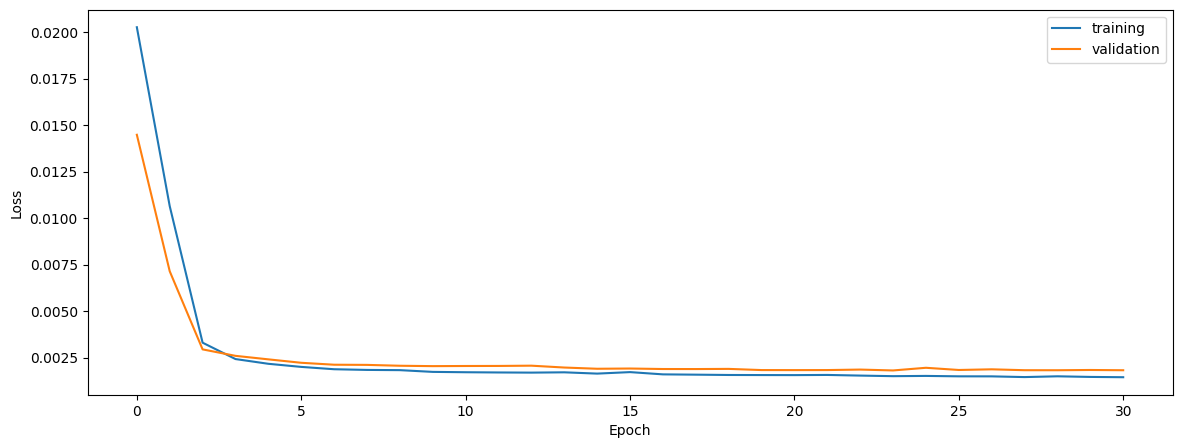

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.9369010186477457
0.9354929208370382
0.9235972242261116


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized
0.9369010186477457
0.9354929208370382
0.9235972242261116


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native
0.941104215632222
0.9384686144343158
0.9331532107434268


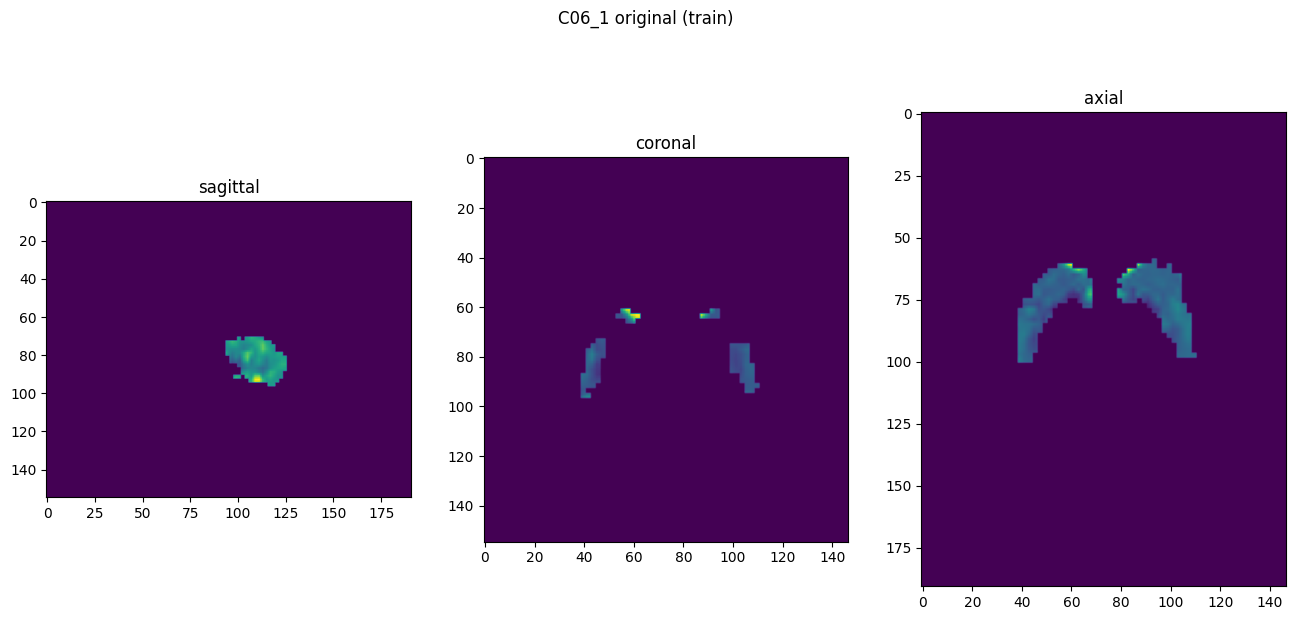

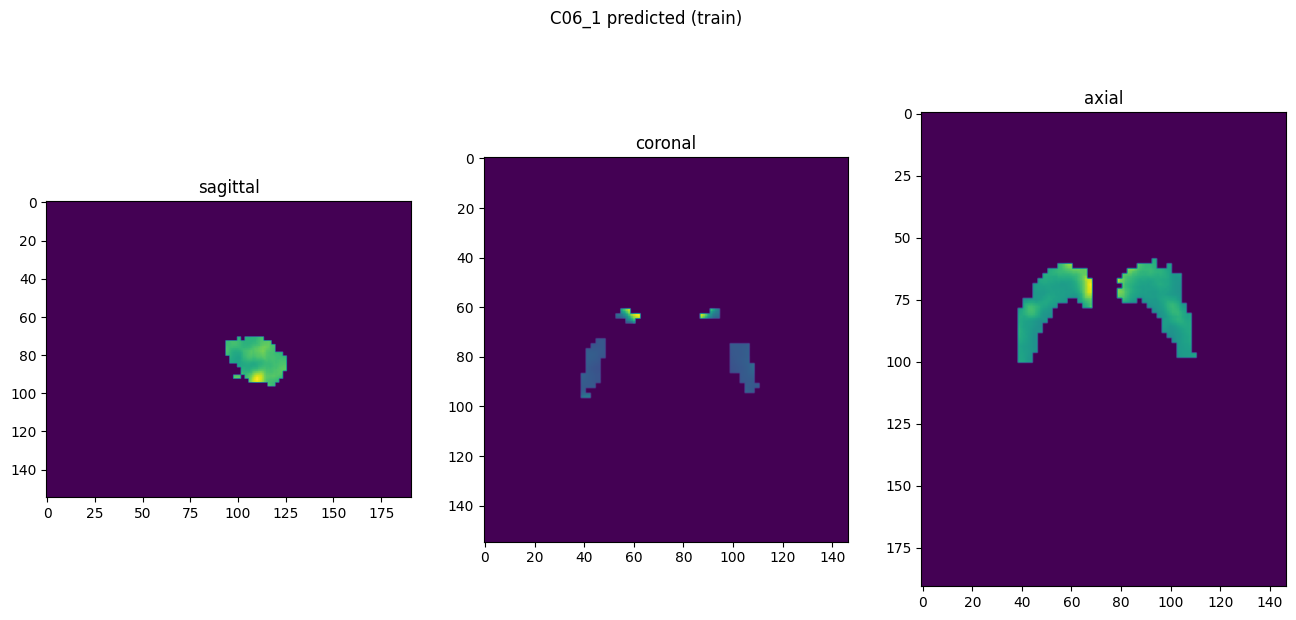

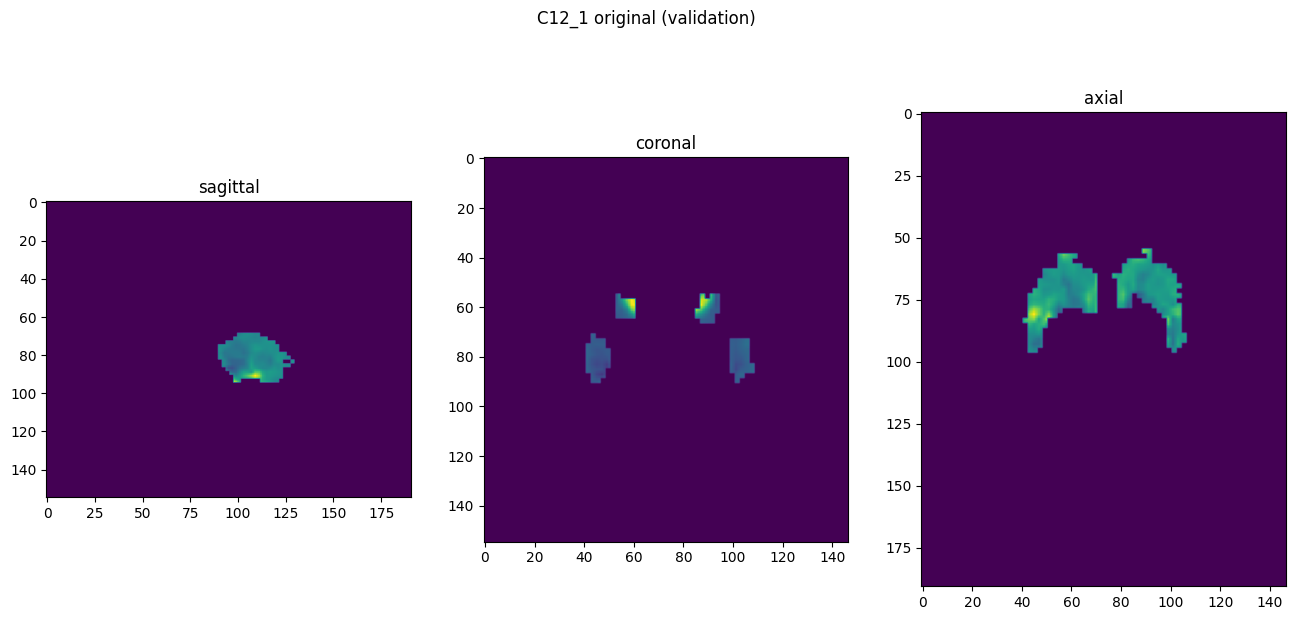

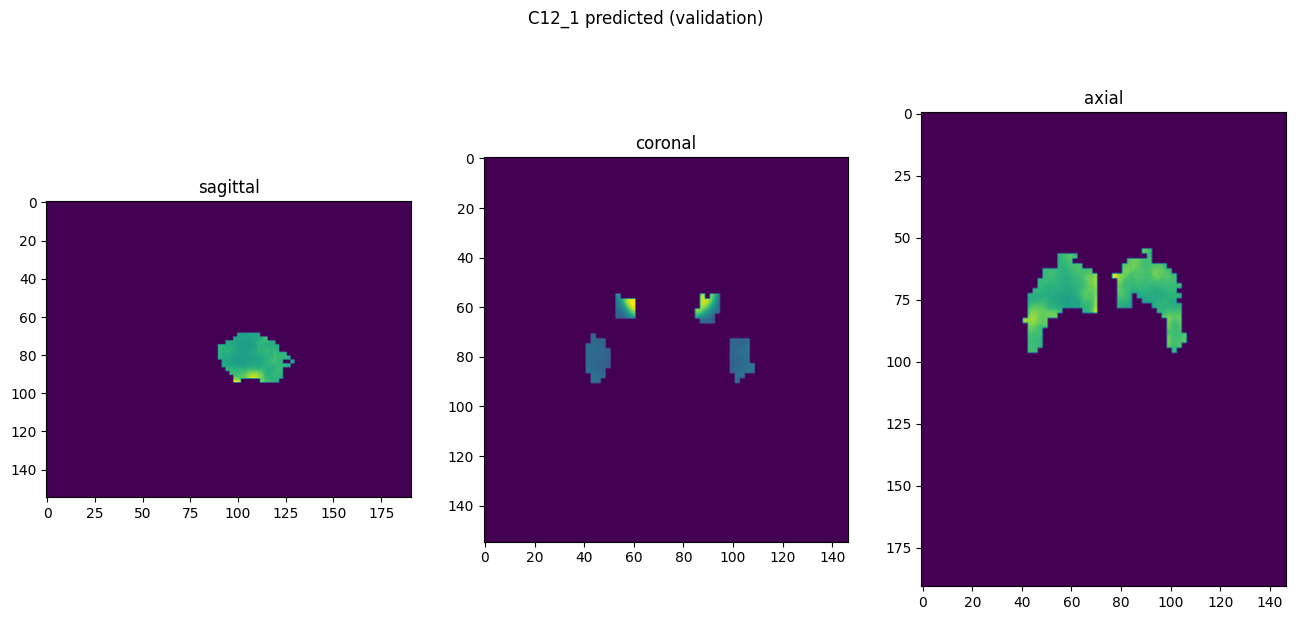

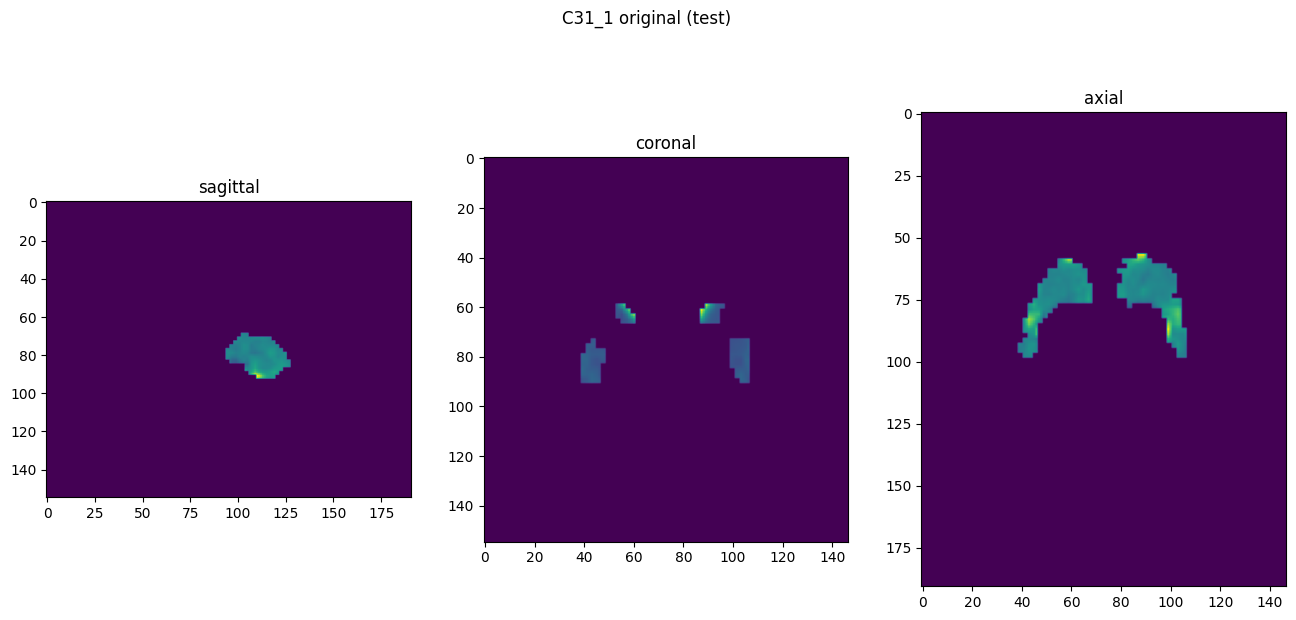

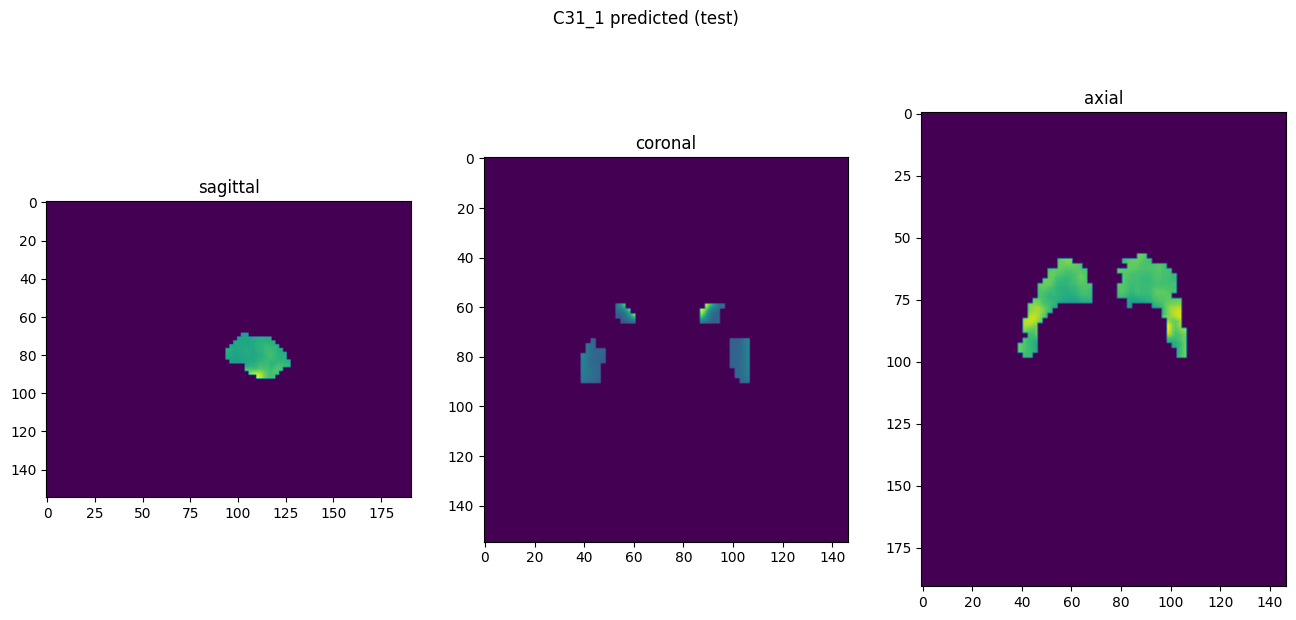

In [10]:
showResults(model, gen, threshold=None, background=False)